<a href="https://colab.research.google.com/github/RishabhL7/Pubnew/blob/main/Linkmob_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils import generic_utils

In [ ]:
!pip install segmentation_models
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git
from classification_models.keras import Classifiers

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/Data.zip'

In [5]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [9]:
path = "//content/Data/hand_data_train/colour"
maskpath = "/content/Data/hand_data_train/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg = cv2.cvtColor(mpg, cv2.COLOR_BGR2GRAY)
    ret, mpg = cv2.threshold(mpg, 120, 255, cv2.THRESH_BINARY)
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:06<00:00, 327.41it/s]


In [20]:
path = "/content/Data/hand_data_test/colour"
maskpath = "/content/Data/hand_data_test/segmentation"
p1 = os.listdir(path)
p1.sort()

m1 = os.listdir(maskpath)
m1.sort()

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(p1):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(m1):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg = cv2.cvtColor(mpg, cv2.COLOR_BGR2GRAY)
    ret, mpg = cv2.threshold(mpg, 120, 255, cv2.THRESH_BINARY)
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:03<00:00, 322.63it/s]


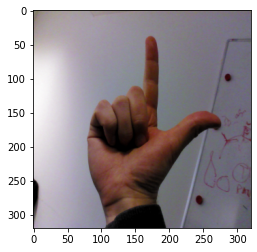

In [10]:
plt.imshow(array_to_img(X_train[0]))

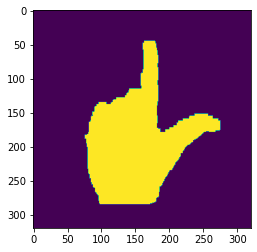

In [11]:
plt.imshow(array_to_img(Y_train[0]))

In [13]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [14]:
def build_LinkNet_mobilenetv2():  
  model = tf.keras.applications.MobileNetV2(input_shape=(320, 320,3), include_top=False, weights="imagenet")

  """ Skip Connections """

  s1 = model.get_layer("block_1_expand_relu").output         ## (160, 160)
  s2 = model.get_layer("block_3_expand_relu").output         ## ( 80, 80)
  s3 = model.get_layer("block_6_expand_relu").output         ## (40, 40)
  s4 = model.get_layer("block_13_expand_relu").output         ## (20, 20)

  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("out_relu").output
  #b1 = ASPP(b1)
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(320, (1,1), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(320, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(576, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(144, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(192, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(48, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(48, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(36, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(36, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(96, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(24, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(24, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

In [15]:
model = build_LinkNet_mobilenetv2()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                               

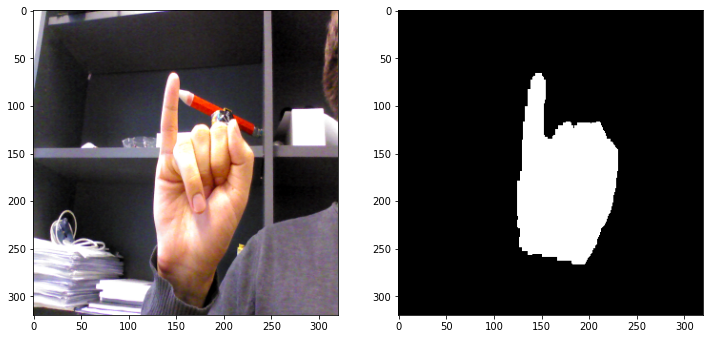

In [17]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number])
plt.subplot(122)
plt.imshow(array_to_img(Y_train[image_number]), cmap='gray')
plt.show()

In [18]:
from tensorflow.keras.optimizers import Adam
model.compile(loss=dice_loss, optimizer=Adam(1e-4), metrics=[dice_coef, iou, "accuracy"])

In [19]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/mobv2link"
os.mkdir(path)
checkpoint_path_segmentdeeplab = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/mobv2link/cp.ckpt"
model_checkpoint_segmentdeeplab = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentdeeplab,
                                                                     save_weights_only=True,
                                                                     monitor='val_iou',
                                                                     mode="max",
                                                                     save_best_only=True,
                                                                     verbose=1,
                                                                     save_freq='epoch',
                                                                     period=100)

In [21]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=16, epochs=500, callbacks=[model_checkpoint_segmentdeeplab])

Epoch 1/500
125/125 [==============================] - 57s 322ms/step - loss: 0.6370 - dice_coef: 0.3630 - iou: 0.2256 - accuracy: 0.8534 - val_loss: 0.6645 - val_dice_coef: 0.3359 - val_iou: 0.2033 - val_accuracy: 0.6871
Epoch 2/500
125/125 [==============================] - 37s 300ms/step - loss: 0.4886 - dice_coef: 0.5114 - iou: 0.3447 - accuracy: 0.9717 - val_loss: 0.5490 - val_dice_coef: 0.4513 - val_iou: 0.2936 - val_accuracy: 0.9349
Epoch 3/500
125/125 [==============================] - 37s 299ms/step - loss: 0.4304 - dice_coef: 0.5696 - iou: 0.3996 - accuracy: 0.9809 - val_loss: 0.4718 - val_dice_coef: 0.5287 - val_iou: 0.3618 - val_accuracy: 0.9664
Epoch 4/500
125/125 [==============================] - 37s 299ms/step - loss: 0.3820 - dice_coef: 0.6180 - iou: 0.4487 - accuracy: 0.9839 - val_loss: 0.4265 - val_dice_coef: 0.5741 - val_iou: 0.4051 - val_accuracy: 0.9724
Epoch 5/500
125/125 [==============================] - 37s 298ms/step - loss: 0.3384 - dice_coef: 0.6616 - iou: 

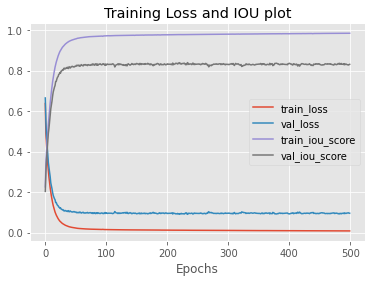

In [22]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = 500
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0,N), history.history["iou"], label = "train_iou_score")
plt.plot(np.arange(0,N), history.history["val_iou"], label = "val_iou_score")
plt.legend(loc="center right")
plt.title("Training Loss and IOU plot")
plt.xlabel("Epochs")
plt.savefig('UNET_Traininerrorplot_SEGMENTATION_RGB.png')

Text(0, 0.5, 'Accuracy')

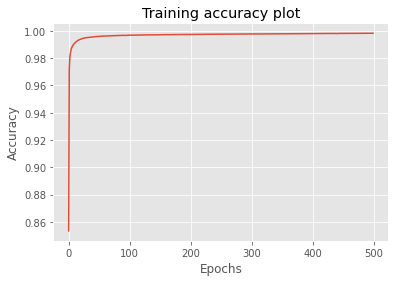

In [23]:
plt.plot(np.arange(0,N), history.history["accuracy"])
plt.title("Training accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Accuracy')

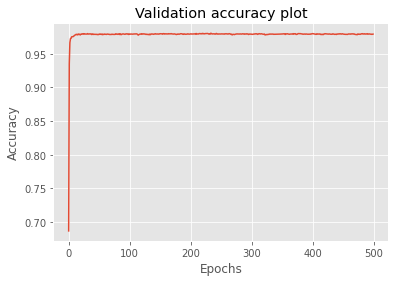

In [24]:
plt.plot(np.arange(0,N), history.history["val_accuracy"], label = "val_accuracy")
plt.title("Validation accuracy plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

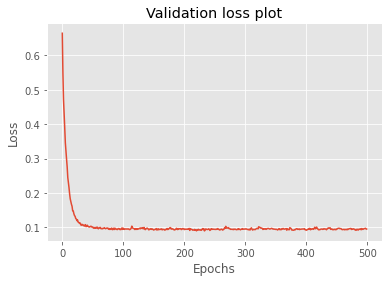

In [25]:
plt.plot(np.arange(0,N), history.history["val_loss"], label = "val_loss")
plt.title("Validation loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Loss')

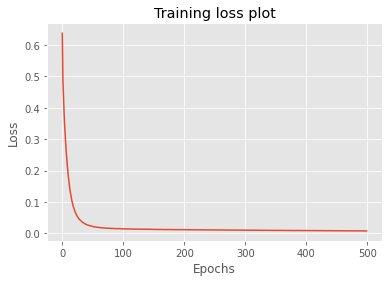

In [26]:
plt.plot(np.arange(0,N), history.history["loss"], label = "val_loss")
plt.title("Training loss plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [27]:
model.save('/content/drive/MyDrive/Colab Notebooks/model_mobv2link_main.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/model_mobv2link_weights.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [28]:
y_pred=model.predict(X_test)

In [29]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.8333722829354965


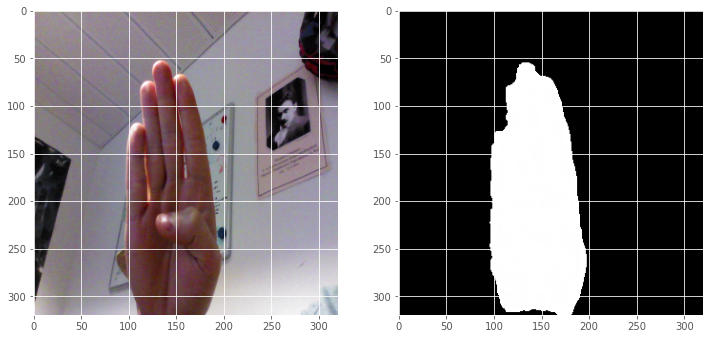

In [32]:
#Prediction test
import random
import numpy as np
image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.subplot(122)
plt.imshow(array_to_img(y_pred[image_number]), cmap='gray')
plt.show()